# Data Project

> **Note:** 
> 1. This is a starting point for how to structure your data project 
> 1. The `dataproject.py` file includes functions which can be in this notebook

Import and set magics:

In [31]:
#!pip install numpy
#!pip install numpy matplotlib
#%pip install git+https://github.com/alemartinello/dstapi
#%pip install fredapi
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# APIs
#from fredapi import Fred
from dstapi import DstApi

# autoreload modules when code is run
%load_ext autoreload
%autoreload 2
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
plt.rcParams.update({'axes.grid':True,'grid.color':'black','grid.alpha':'0.25','grid.linestyle':'--'})
plt.rcParams.update({'font.size': 14})

# user written modules
import dataproject

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Question 1

We load the data from ....

In [32]:
data = dataproject.load_data()

In [33]:
# We can access data from the DST API as follows:
PRIS113 = DstApi('PRIS113')
PRIS113.tablesummary(language='en')

Table PRIS113: Consumer price index by type and time
Last update: 2025-10-10T08:00:00


,variable name,# values,First value,First value label,Last value,Last value label,Time variable
0,TYPE,1,INDEKS,Consumer price index,INDEKS,Consumer price index,False
1,Tid,549,1980M01,1980M01,2025M09,2025M09,True


In [34]:
#a. Set download parameters
params = {
    'table': 'PRIS113',
    'format': 'BULK', # semicolon separated file
    'lang': 'en',
    'variables': [
        {'code': 'TYPE', 'values': ['INDEKS']},
        {'code': 'Tid', 'values': ['*']}, # '' is everything
        ]
    }

#b. Download
CPI = PRIS113.get_data(params=params)
CPI.head()

CPI['DATE'] = pd.to_datetime(CPI['TID'], format='%YM%m')
CPI = CPI.drop(columns=['TID'])
CPI = CPI.drop(columns=['TYPE'])
CPI = CPI.set_index('DATE')
CPI = CPI.rename(columns={'INDHOLD': 'CPI'})
CPI = CPI.sort_index()
CPI.head()

,CPI
DATE,
1980-01-01,33.0
1980-02-01,33.3
1980-03-01,33.8
1980-04-01,34.0
1980-05-01,34.5


In [35]:
# Konverter CPI-kolonnen til tal
CPI["CPI"] = pd.to_numeric(CPI["CPI"], errors="coerce")

CPI = CPI.set_index('DATE')

In [36]:
# Beregner forbrugerprisindeks, hovedtal (2020=100) 
base_2020 = CPI.loc[CPI.index.year == 2020, "CPI"].mean()
CPI["P_t"] = CPI["CPI"] / base_2020 * 100
CPI

,CPI,P_t
DATE,,
1980-01-01,33.0,31.904608
1980-02-01,33.3,32.194650
1980-03-01,33.8,32.678053
1980-04-01,34.0,32.871415
1980-05-01,34.5,33.354818
...,...,...
2025-05-01,120.4,116.403481
2025-06-01,120.7,116.693522
2025-07-01,122.5,118.433774


In [37]:
#2.  month-to-month inflation rate
CPI['pi_month'] = CPI['P_t'].pct_change()*100

#3.  12-month inflation rate
CPI['pi_year'] = CPI['P_t'].pct_change(12)*100
CPI

,CPI,P_t,pi_month,pi_year
DATE,,,,
1980-01-01,33.0,31.904608,NaN,NaN
1980-02-01,33.3,32.194650,0.909091,NaN
1980-03-01,33.8,32.678053,1.501502,NaN
1980-04-01,34.0,32.871415,0.591716,NaN
1980-05-01,34.5,33.354818,1.470588,NaN
...,...,...,...,...
2025-05-01,120.4,116.403481,0.083126,1.603376
2025-06-01,120.7,116.693522,0.249169,1.856540
2025-07-01,122.5,118.433774,1.491301,2.253756


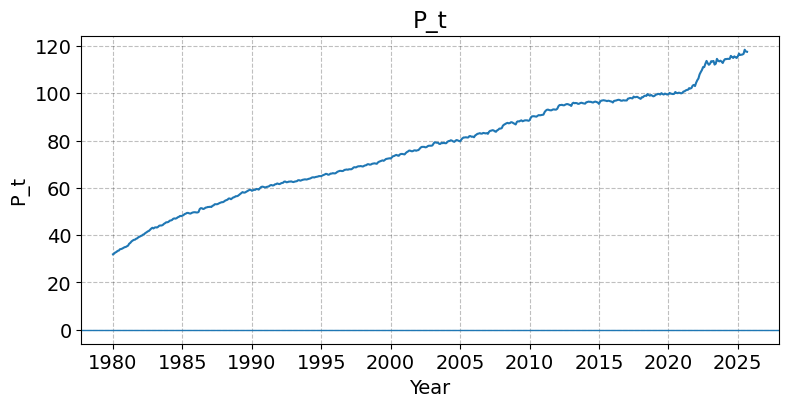

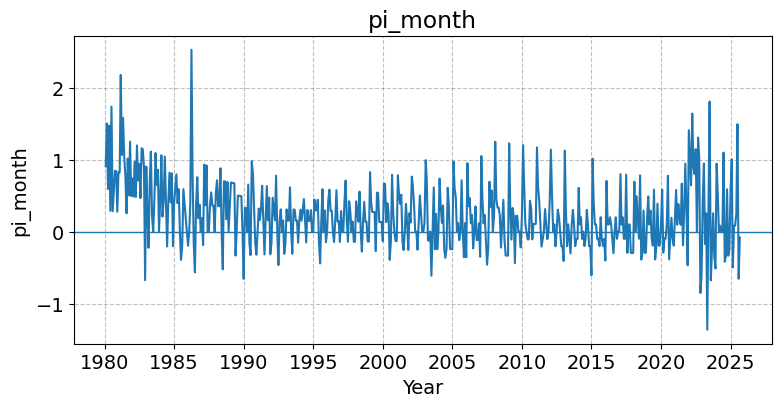

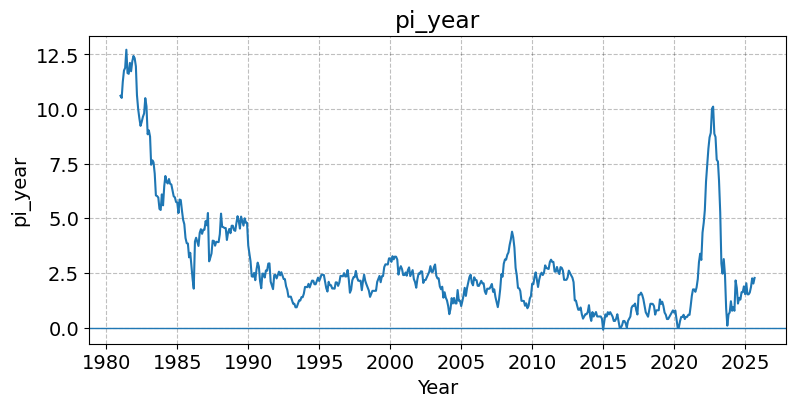

In [38]:
cols = ["P_t", "pi_month", "pi_year"]  # vælg de kolonner du vil plotte

for col in cols:
    fig = plt.figure(figsize=(9,4))
    ax = fig.add_subplot(111)
    ax.plot(CPI.index, CPI[col])
    ax.set_title(col)
    ax.set_xlabel('Year')
    ax.set_ylabel(col)
    ax.axhline(0, linewidth=1)
    plt.show()

## Question 2

We process the data by ...

In [39]:
data = dataproject.process_data(data)

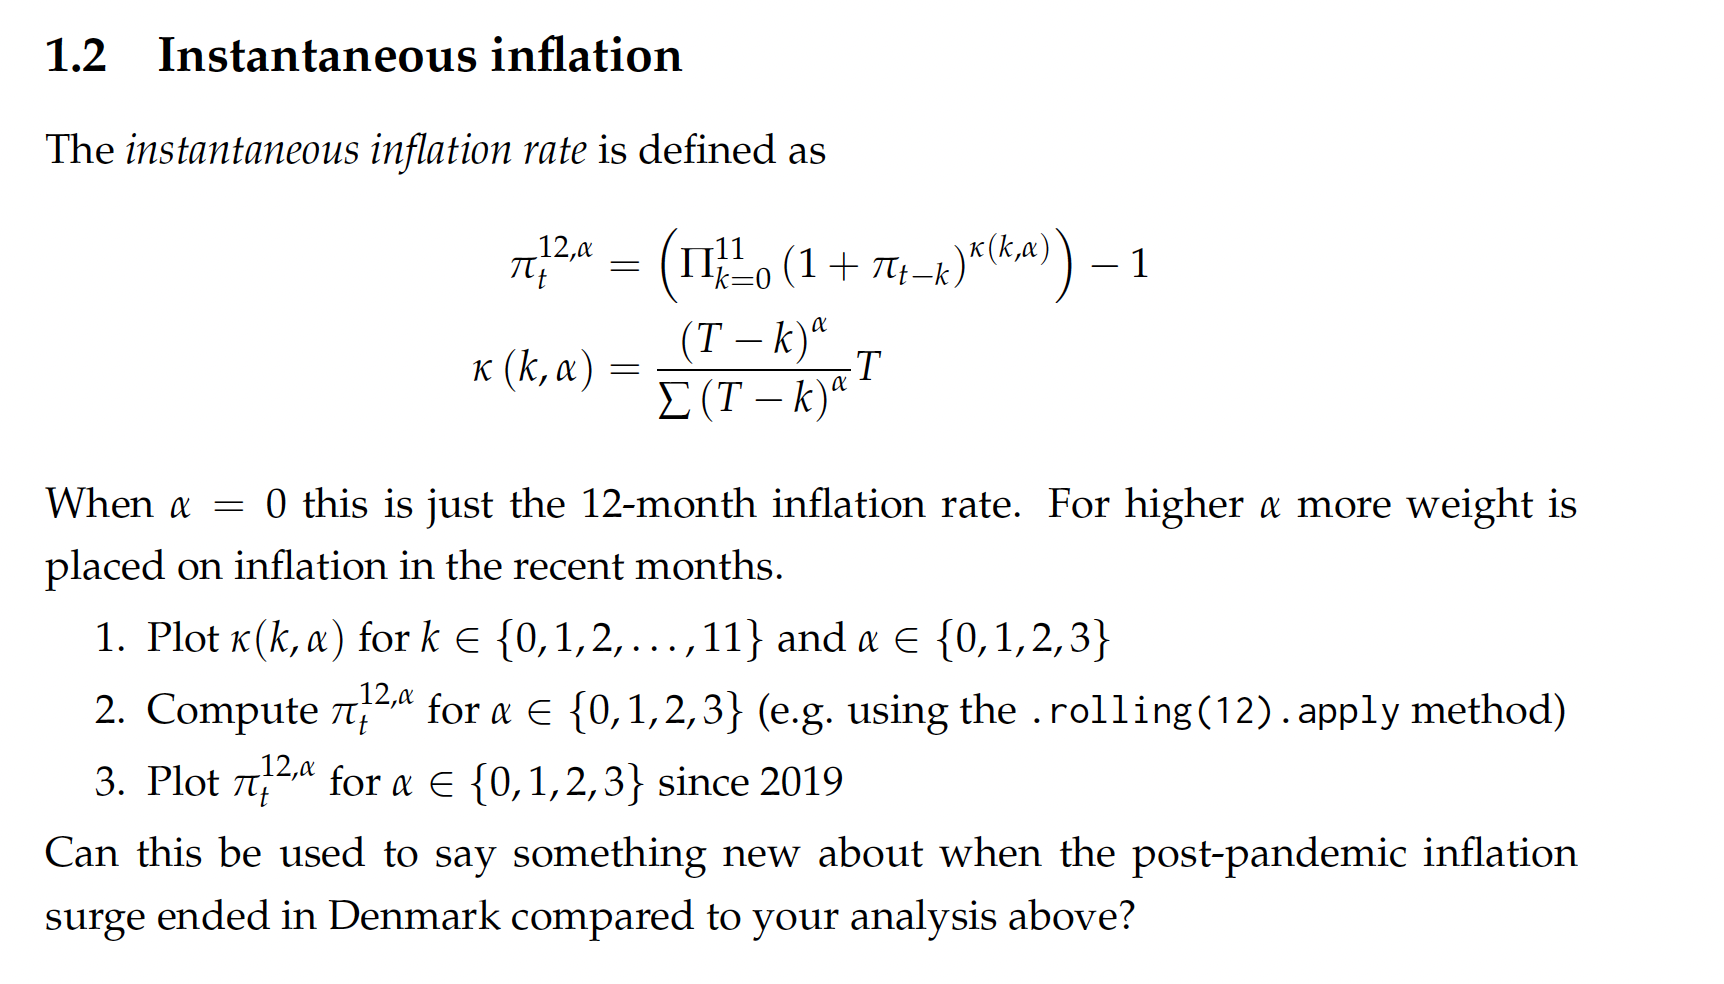

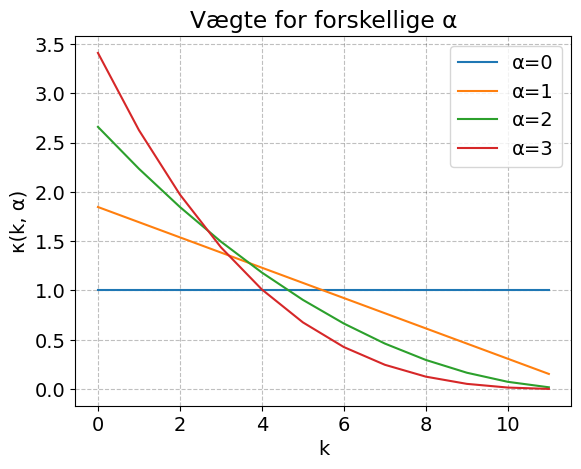

In [40]:
#Version 1
def kappa(k, alpha, T=12):
    # k = np.array(k) 
    numerator = (T - k) ** alpha
    denominator = np.sum([(T - j) ** alpha for j in range(T)])
    return numerator / denominator * T

T = 12
ks = np.arange(T)
alphas = [0, 1, 2, 3]

for alpha in alphas:
    kappas = [kappa(k, alpha, T) for k in ks]
    plt.plot(ks, kappas, label=f'α={alpha}')
plt.xlabel('k')
plt.ylabel('κ(k, α)')
plt.title('Vægte for forskellige α')
plt.legend()
plt.show()

Now I will solve 1.2.2

In [41]:
def kappa_vec(alpha, T=12):
    k = np.arange(T)
    numerator = (T - k) ** alpha
    denominator = np.sum((T - np.arange(T)) ** alpha)
    return numerator / denominator * T

def pi_instant(window, alpha):
    kappas = kappa_vec(alpha, T=len(window))
    # window[-k-1] er pi_{t-k}, så vi vender rækkefølgen
    infl = np.prod((1 + window[::-1]/100) ** kappas) - 1
    return infl * 100  # procent

for alpha in [0, 1, 2, 3]:
    CPI[f'pi_inst_{alpha}'] = (
        CPI['pi_month']
        .rolling(window=12, min_periods=12)
        .apply(lambda x: pi_instant(x, alpha), raw=True)
    )

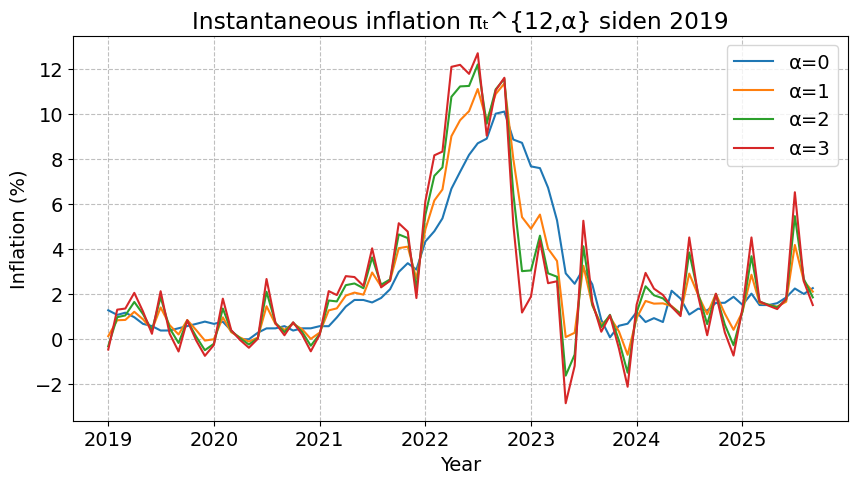

In [42]:
plt.figure(figsize=(10,5))
for alpha in [0, 1, 2, 3]:
    plt.plot(
        CPI.loc["2019":].index, 
        CPI.loc["2019":, f"pi_inst_{alpha}"], 
        label=f"α={alpha}"
    )
plt.title("Instantaneous inflation πₜ^{12,α} siden 2019")
plt.xlabel("Year")
plt.ylabel("Inflation (%)")
plt.legend()
plt.show()

In [60]:
%pip install fredapi
from fredapi import Fred


Note: you may need to restart the kernel to use updated packages.


In [61]:
with open('/Users/macbook/Desktop/4 semester - 11. semester/Programming for Economists /fredapi.txt', 'r') as f: fred_api_key = f.read()
fred = Fred(api_key=fred_api_key)

In [62]:
series = {
     "GDPCA":"RealGDP",
     "CNP16OV":"Pop",
     "CE16OV":"Employment",
     "B4701C0A222NBEA":"TotalHours",
}

In [64]:
#for k in series.keys():
#   display(fred.search(k)[['title','frequency','units']].T)

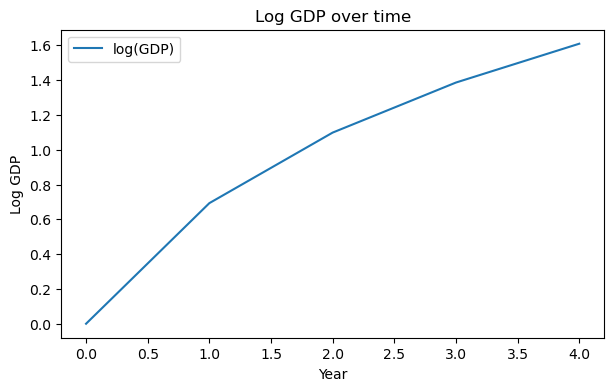

In [4]:
fig = plt.figure(figsize=(7,4))
ax = fig.add_subplot(111)

ax.plot(data['log_GDP'],label='log(GDP)')

ax.set_title('Log GDP over time')
ax.set_xlabel('Year')
ax.set_ylabel('Log GDP')

ax.legend();

We find that that ...